In [33]:
import os
import errno
import argparse
import sys
import pickle

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

from data_utils import load_CIFAR_data, generate_partial_data, generate_bal_private_data, load_FEMNIST_data, load_MNIST_data
from FedMD import FedMD
from Neural_Networks import train_models, cnn_2layer_fc_model, cnn_3layer_fc_model

import numpy as np
from tensorflow.keras.models import clone_model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from utility import * 
from data_utils import generate_alignment_data
from Neural_Networks import remove_last_layer

## Functions and Configurations

In [25]:
# CIFAR-10 config

CANDIDATE_MODELS = {"2_layer_CNN": cnn_2layer_fc_model, 
                    "3_layer_CNN": cnn_3layer_fc_model} 

conf_file = os.path.abspath("conf/CIFAR_balance_conf.json")

with open(conf_file, "r") as f:
    conf_dict = eval(f.read())
    
    #n_classes = conf_dict["n_classes"]
    model_config = conf_dict["models"]
    pre_train_params = conf_dict["pre_train_params"]
    model_saved_dir = conf_dict["model_saved_dir"]
    model_saved_names = conf_dict["model_saved_names"]
    is_early_stopping = conf_dict["early_stopping"]
    public_classes = conf_dict["public_classes"]
    private_classes = conf_dict["private_classes"]
    n_classes = len(public_classes) + len(private_classes)
    
    emnist_data_dir = conf_dict["EMNIST_dir"]    
    N_parties = conf_dict["N_parties"]
    N_samples_per_class = conf_dict["N_samples_per_class"]
    
    N_rounds = conf_dict["N_rounds"]
    N_alignment = conf_dict["N_alignment"]
    N_private_training_round = conf_dict["N_private_training_round"]
    private_training_batchsize = conf_dict["private_training_batchsize"]
    N_logits_matching_round = conf_dict["N_logits_matching_round"]
    logits_matching_batchsize = conf_dict["logits_matching_batchsize"]
    aug = conf_dict["aug"]
    compress = conf_dict["compress"]
    
    
    result_save_dir = conf_dict["result_save_dir"]

del conf_dict, conf_file

In [27]:
#FEMNIST conifg

CANDIDATE_MODELS = {"2_layer_CNN": cnn_2layer_fc_model, 
                    "3_layer_CNN": cnn_3layer_fc_model} 

conf_file = os.path.abspath("conf/EMNIST_balance_conf.json")
with open(conf_file, "r") as f:
    conf_dict = eval(f.read())
    
    #n_classes = conf_dict["n_classes"]
    model_config = conf_dict["models"]
    pre_train_params = conf_dict["pre_train_params"]
    model_saved_dir = conf_dict["model_saved_dir"]
    model_saved_names = conf_dict["model_saved_names"]
    is_early_stopping = conf_dict["early_stopping"]
    public_classes = conf_dict["public_classes"]
    private_classes = conf_dict["private_classes"]
    n_classes = len(public_classes) + len(private_classes)
    
    emnist_data_dir = conf_dict["EMNIST_dir"]    
    N_parties = conf_dict["N_parties"]
    N_samples_per_class = conf_dict["N_samples_per_class"]
    
    N_rounds = conf_dict["N_rounds"]
    N_alignment = conf_dict["N_alignment"]
    N_private_training_round = conf_dict["N_private_training_round"]
    private_training_batchsize = conf_dict["private_training_batchsize"]
    N_logits_matching_round = conf_dict["N_logits_matching_round"]
    logits_matching_batchsize = conf_dict["logits_matching_batchsize"]
    
    
    result_save_dir = conf_dict["result_save_dir"]

In [28]:
N_samples_per_class

5

## Play 


## Load CIFAR10 data

In [3]:


X_train_CIFAR10, y_train_CIFAR10, X_test_CIFAR10, y_test_CIFAR10 \
= load_CIFAR_data(data_type="CIFAR10", 
                    standarized = True, verbose = True)

public_dataset = {"X": X_train_CIFAR10, "y": y_train_CIFAR10}


X_train_CIFAR100, y_train_CIFAR100, X_test_CIFAR100, y_test_CIFAR100 \
= load_CIFAR_data(data_type="CIFAR100",
                    standarized = True, verbose = True)

# only use those CIFAR100 data whose y_labels belong to private_classes
X_train_CIFAR100, y_train_CIFAR100 \
= generate_partial_data(X = X_train_CIFAR100, y= y_train_CIFAR100,
                        class_in_use = private_classes, 
                        verbose = True)


X_test_CIFAR100, y_test_CIFAR100 \
= generate_partial_data(X = X_test_CIFAR100, y= y_test_CIFAR100,
                        class_in_use = private_classes, 
                        verbose = True)

# relabel the selected CIFAR100 data for future convenience
for index, cls_ in enumerate(private_classes):        
    y_train_CIFAR100[y_train_CIFAR100 == cls_] = index + len(public_classes)
    y_test_CIFAR100[y_test_CIFAR100 == cls_] = index + len(public_classes)
del index, cls_

print(pd.Series(y_train_CIFAR100).value_counts())
mod_private_classes = np.arange(len(private_classes)) + len(public_classes)

print("="*60)
#generate private data
private_data, total_private_data\
=generate_bal_private_data(X_train_CIFAR100, y_train_CIFAR100,      
                            N_parties = N_parties,           
                            classes_in_use = mod_private_classes, 
                            N_samples_per_class = N_samples_per_class, 
                            data_overlap = False)

print("="*60)
X_tmp, y_tmp = generate_partial_data(X = X_test_CIFAR100, y= y_test_CIFAR100,
                                        class_in_use = mod_private_classes, 
                                        verbose = True)
private_test_data = {"X": X_tmp, "y": y_tmp}
del X_tmp, y_tmp

parties = []
if model_saved_dir is None:
    for i, item in enumerate(model_config):
        model_name = item["model_type"]
        model_params = item["params"]
        tmp = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                            input_shape=(32,32,3),
                                            **model_params)
        print("model {0} : {1}".format(i, model_saved_names[i]))
        # print(tmp.summary())
        parties.append(tmp)


X_train shape : (50000, 32, 32, 3)
X_test shape : (10000, 32, 32, 3)
y_train shape : (50000,)
y_test shape : (10000,)
X_train shape : (50000, 32, 32, 3)
X_test shape : (10000, 32, 32, 3)
y_train shape : (50000,)
y_test shape : (10000,)
X shape : (3000, 32, 32, 3)
y shape : (3000,)
X shape : (600, 32, 32, 3)
y shape : (600,)
10    500
15    500
14    500
12    500
13    500
11    500
dtype: int64
X shape : (600, 32, 32, 3)
y shape : (600,)
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-08-01 17:57:27.940421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-01 17:57:27.942579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/gadmohamed/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


model 0 : CNN_128_256
model 1 : CNN_128_384
model 2 : CNN_128_512
model 3 : CNN_256_256
model 4 : CNN_256_512
model 5 : CNN_64_128_256
model 6 : CNN_64_128_192
model 7 : CNN_128_192_256
model 8 : CNN_128_128_128
model 9 : CNN_128_128_192
model 10 : CNN_128_256
model 11 : CNN_128_384
model 12 : CNN_128_512
model 13 : CNN_256_256
model 14 : CNN_256_512
model 15 : CNN_64_128_256
model 16 : CNN_64_128_192
model 17 : CNN_128_192_256
model 18 : CNN_128_128_128
model 19 : CNN_128_128_192


## Load FASHION MNIST dataset

In [29]:

X_train_MNIST, y_train_MNIST, X_test_MNIST, y_test_MNIST \
= load_MNIST_data(standarized = True, verbose = True)

public_dataset = {"X": X_train_MNIST, "y": y_train_MNIST}


X_train_EMNIST, y_train_EMNIST, X_test_EMNIST, y_test_EMNIST \
= load_FEMNIST_data(standarized = True, verbose = True)

y_train_EMNIST = y_train_EMNIST + len(public_classes)
y_test_EMNIST = y_test_EMNIST + len(public_classes)

print("y train femnist unique:", np.unique(y_train_EMNIST))
print("y test femnist unique:", np.unique(y_test_EMNIST)) 
print("private classes:", private_classes)

#generate private data
private_data, total_private_data \
= generate_bal_private_data(X_train_EMNIST, y_train_EMNIST, 
                            N_parties = N_parties,             
                            classes_in_use = private_classes, 
                            N_samples_per_class = N_samples_per_class, 
                            data_overlap = False)

X_tmp, y_tmp = generate_partial_data(X = X_test_EMNIST, y= y_test_EMNIST, 
                                        class_in_use = private_classes, verbose = True)
private_test_data = {"X": X_tmp, "y": y_tmp}
del X_tmp, y_tmp

parties = []
if model_saved_dir is None:
    for i, item in enumerate(model_config):
        model_name = item["model_type"]
        model_params = item["params"]
        tmp = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                            input_shape=(28,28),
                                            **model_params)
        print("model {0} : {1}".format(i, model_saved_names[i]))
        # print(tmp.summary())
        parties.append(tmp)
        
        del model_name, model_params, tmp
    #END FOR LOOP
#     pre_train_result = train_models(parties, 
#                                     X_train_MNIST, y_train_MNIST, 
#                                     X_test_MNIST, y_test_MNIST,
#                                     save_dir = model_saved_dir, save_names = model_saved_names,
#                                     early_stopping = is_early_stopping,
#                                     **pre_train_params
#                                    )
else:
    dpath = os.path.abspath(model_saved_dir)
    model_names = os.listdir(dpath)
    for name in model_names:
        tmp = None
        tmp = load_model(os.path.join(dpath ,name))
        parties.append(tmp)


MNIST dataset ... 
X_train shape : (60000, 28, 28)
X_test shape : (10000, 28, 28)
y_train shape : (60000,)
y_test shape : (10000,)
shape: (60000,)
unique: [0 1 2 3 4 5 6 7 8 9]
EMNIST-letter dataset ... 
X_train shape : (60000, 28, 28)
X_test shape : (10000, 28, 28)
y_train shape : (60000,)
y_test shape : (10000,)
y train femnist unique: [ 9 10 11 12 13 14 15 16 17 18]
y test femnist unique: [ 9 10 11 12 13 14 15 16 17 18]
private classes: [10, 11, 12, 13, 14, 15]
X shape : (6000, 28, 28)
y shape : (6000,)


/Users/gadmohamed/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


model 0 : CNN_128_256
model 1 : CNN_128_384
model 2 : CNN_128_512
model 3 : CNN_256_256
model 4 : CNN_256_512
model 5 : CNN_64_128_256
model 6 : CNN_64_128_192
model 7 : CNN_128_192_256
model 8 : CNN_128_128_128
model 9 : CNN_128_128_192


In [39]:
size_of(public_dataset['X'][:500]), size_of(parties[0])

(3136.0, 3960.832)

# Training

In [5]:
new_total_private_data = {}
new_total_private_data['X'] = np.concatenate([p['X'] for p in private_data ], axis = 0)
new_total_private_data['y'] = np.concatenate([p['y'] for p in private_data ], axis = 0)

print(private_data[0]['X'].shape, total_private_data['X'].shape, new_total_private_data['X'].shape)

(30, 28, 28) (300, 28, 28) (300, 28, 28)


In [8]:
input_shape = private_data[0]["X"].shape[1:]
[0.5483333468437195, 0.5421666502952576, 0.6263333559036255, 0.4596666693687439, 0.5808333158493042, 0.6393333077430725, 0.6313333511352539, 0.5663333535194397, 0.5171666741371155, 0.503333330154419]

local_accuracies = [] 
for i in range(len(private_data)):

    tf.keras.backend.clear_session()
    item = model_config[0]
    model_name = item["model_type"]
    model_params = item["params"]
    model_ub = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                        input_shape=input_shape,
                                        **model_params)
    model_ub.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
                        loss = "sparse_categorical_crossentropy", 
                        metrics = ["accuracy"])
    ub_history = model_ub.fit(private_data[i]['X'], private_data[i]['y'],
                    batch_size = 30, epochs = 30, shuffle=True, verbose = False, 
                    validation_data = [private_test_data["X"], private_test_data["y"]],
                    callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=7, restore_best_weights=True)])

    local_accuracies.append(ub_history.history["val_accuracy"])
    print("final accuracy:", ub_history.history["val_accuracy"][-1])


/Users/gadmohamed/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-08-01 18:03:07.843204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:03:08.660526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5483333468437195


2023-08-01 18:04:12.302802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:04:12.962582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5421666502952576


2023-08-01 18:05:35.799007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:05:36.519702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.6263333559036255


2023-08-01 18:06:46.088848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:06:46.779286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.4596666693687439


2023-08-01 18:07:45.558394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:07:46.145240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5808333158493042


2023-08-01 18:08:54.509563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:08:55.590074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.6393333077430725


2023-08-01 18:10:19.766894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:10:20.532367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.6313333511352539


2023-08-01 18:11:23.822964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:11:24.793714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5663333535194397


2023-08-01 18:12:23.219436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:12:23.865058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.5171666741371155


2023-08-01 18:13:35.049149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-01 18:13:35.673221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


final accuracy: 0.503333330154419


average: 0.5614833354949951


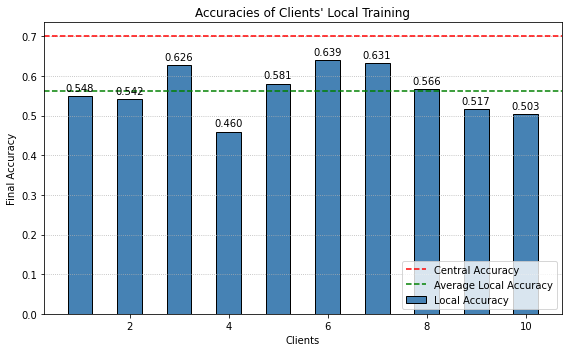

In [23]:
import matplotlib.pyplot as plt

# Data for the bar plot
accuracies = [0.5483333468437195, 0.5421666502952576, 0.6263333559036255, 0.4596666693687439, 0.5808333158493042, 0.6393333077430725, 0.6313333511352539, 0.5663333535194397, 0.5171666741371155, 0.503333330154419]

# Clients for the x-axis (assuming one accuracy value per client)
clients = range(1, len(accuracies) + 1)

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the bar chart with custom colors, edgecolor, and width
bars = ax.bar(clients, accuracies, color='steelblue', edgecolor='black', width=0.5, label = 'Local Accuracy')

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Set x and y axis labels and title
ax.set_xlabel('Clients')
ax.set_ylabel('Final Accuracy')
ax.set_title('Accuracies of Clients\' Local Training')

# Add a horizontal line at accuracy 70 to mark it as the central accuracy
ax.axhline(y=0.70, color='red', linestyle='--', label='Central Accuracy')

# Add a horizontal line for the average accuracy local 
ax.axhline(y=sum(accuracies)/len(accuracies), color='green', linestyle='--', label='Average Local Accuracy')

print("average:", sum(accuracies)/len(accuracies))
# Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
plt.tight_layout()

# Add a legend with position right bottom
plt.legend(loc='lower right')

# Save the plot as a high-quality PDF
plt.savefig('local_central.pdf', dpi=300)

# Show the plot
plt.show()


In [13]:
    
central_trials = [] 
for i in range(len(central_trials)) : 
    tf.keras.backend.clear_session()
    input_shape = private_data[0]["X"].shape[1:]

    cbs = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=7, restore_best_weights=True)]
    cbs = [] 

    item = model_config[0]
    model_name = item["model_type"]
    model_params = item["params"]
    model_ub = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                        input_shape=input_shape,
                                        **model_params)
    model_ub.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
                        loss = "sparse_categorical_crossentropy", 
                        metrics = ["accuracy"])
    print("shpae of private data:", private_data[0]["X"].shape)
    ub_history = model_ub.fit(new_total_private_data['X'], new_total_private_data['y'],
                    batch_size = 30, epochs = 40, shuffle=True, verbose = True, 
                    validation_data = [private_test_data["X"], private_test_data["y"]],
                    callbacks=[cbs])

    central_trials.append(ub_history.history["val_accuracy"])
    print("final accuracy:", ub_history.history["val_accuracy"][-1])


shpae of private data: (30, 28, 28)
Epoch 1/40


2023-08-01 18:26:52.598060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 45.3963 - accuracy: 0.4167

2023-08-01 18:26:54.329171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 736ms/step - loss: 45.3963 - accuracy: 0.4167 - val_loss: 11.3624 - val_accuracy: 0.5538
Epoch 2/40
10/10 [==============================] - 6s 678ms/step - loss: 30.7086 - accuracy: 0.5933 - val_loss: 8.2338 - val_accuracy: 0.5517
Epoch 3/40
10/10 [==============================] - 6s 632ms/step - loss: 16.7139 - accuracy: 0.6833 - val_loss: 4.6102 - val_accuracy: 0.6097
Epoch 4/40
10/10 [==============================] - 6s 636ms/step - loss: 9.1421 - accuracy: 0.7967 - val_loss: 6.1529 - val_accuracy: 0.3782
Epoch 5/40
10/10 [==============================] - 6s 666ms/step - loss: 6.8224 - accuracy: 0.7900 - val_loss: 11.0969 - val_accuracy: 0.1817
Epoch 6/40
10/10 [==============================] - 8s 819ms/step - loss: 5.2864 - accuracy: 0.8167 - val_loss: 13.3177 - val_accuracy: 0.1917
Epoch 7/40
10/10 [==============================] - 7s 802ms/step - loss: 3.9537 - accuracy: 0.8433 - val_loss: 12.1165 - val_accuracy: 0.2738
Epoch 8/40

In [ ]:
np.mean(local_trials), np.std(local_trials)

In [ ]:
np.mean(central_trials), np.std(central_trials)